
# ------------------------------------------------------------------
# Tweet Analysis
# ------------------------------------------------------------------


# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignora UserWarnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Ignora ConvergenceWarnings

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pymongo import MongoClient
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

import pyspark
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.functions import expr
from pyspark.sql.functions import col, sum, to_date, avg, to_timestamp, date_format, count
from pyspark.sql import SparkSession

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization, TimeDistributed
from tensorflow.keras.layers import Activation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Big Data

## PySpark 

### Configuring SparkSession with Increased Memory

In [28]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MongoDB to Spark with Custom Partitions") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.memory", "8g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.rpc.message.maxSize", "256") \
    .config("spark.mongodb.input.partitionerOptions.partitionSizeMB", "32") \
    .config("spark.mongodb.input.partitionerOptions.numberOfPartitions", "200") \
    .getOrCreate()

print("SparkSession successful!")



SparkSession successful!


### Checking the Versions

In [29]:
print(pyspark.__version__)

3.4.3


In [30]:
# Inicializar uma sessão Spark
#spark = SparkSession.builder.appName("TSV Loader").getOrCreate()

# Creating SparkSession
#spark = SparkSession.builder.master("local[4]").appName("PyMongo_Spark").getOrCreate()

In [31]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.sparkContext.setLogLevel("INFO")

In [32]:
spark.version

'3.4.3'

## MongoDB

### MongoDB Connection

In [22]:
from pymongo import MongoClient

# Modify this URI if needed
mongo_uri = "mongodb://127.0.0.1:27017/"  # Update this if MongoDB is hosted elsewhere
client = MongoClient(mongo_uri)           # If MongoDB is hosted on a different computer or port, modify the `mongo_uri` variable in the connection cell.

In [23]:
# Connecting to the database and collection
db = client['mastercct']
collection = db['tweets']

In [24]:
print("Successfully connected to MongoDB!")

Successfully connected to MongoDB!


### Loading the Data from MongoDB using Spark

In [36]:
# Loading Data from MongoDB an putting in a Pandas Dataframe
cursor = collection.find()
data = list(cursor)
df = pd.DataFrame(data)

In [37]:
# Adjusting the Schema for include all the columns
schema = StructType([
    StructField("_id", StringType(), True),
    StructField("-", StringType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("tweet", StringType(), True)
])

In [38]:
# Splitting the data in partitions manually when create RDD
num_partitions = 200 
rdd = spark.sparkContext.parallelize(data, numSlices=num_partitions)

In [39]:
# Creating the Spark Datafram with RDD
spark_df = spark.createDataFrame(rdd.map(lambda x: {
    "_id": str(x.get("_id", "")),
    "-": x.get("-", ""),
    "id": x.get("id", ""),
    "date": x.get("date", ""),
    "flag": x.get("flag", ""),
    "user": x.get("user", ""),
    "tweet": x.get("tweet", "")
}), schema=schema)


In [40]:
# Chcking the Number of Partitions
print(f"Initial partitions: {spark_df.rdd.getNumPartitions()}")

Initial partitions: 200


## Dataset

### Checking the Dataset

In [7]:
spark_df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|  -|        id|                date|    flag|           user|               tweet|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [8]:
spark_df.printSchema()

root
 |-- -: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- tweet: string (nullable = true)



### Dropping Columns

In [9]:
spark_df = spark_df.drop('-','id','flag')

## Map Reduce Processing

### Data Preparation

In [10]:
# Convrting Timestamp for Date
spark_df = spark_df.withColumn("date", to_timestamp(spark_df["date"], "EEE MMM dd HH:mm:ss zzz yyyy"))

In [11]:
spark_df = spark_df.withColumn("date", to_date(col("date")))

In [12]:
# Removing Missing Values
spark_df = spark_df.filter(col('tweet').isNotNull())

In [13]:
# Selecting relevant columns
tweets_df = spark_df.select('date','tweet')

### Sentimental Analysis

In [14]:
def analyse_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"

In [15]:
sentiment_udf = udf(analyse_sentiment,StringType())

In [16]:
tweets_df = tweets_df.withColumn("sentiment",sentiment_udf(col("tweet")))

In [17]:
tweets_df.show()

+----------+--------------------+---------+
|      date|               tweet|sentiment|
+----------+--------------------+---------+
|2009-04-07|@switchfoot http:...| positive|
|2009-04-07|is upset that he ...|  neutral|
|2009-04-07|@Kenichan I dived...| positive|
|2009-04-07|my whole body fee...| positive|
|2009-04-07|@nationwideclass ...| negative|
|2009-04-07|@Kwesidei not the...| positive|
|2009-04-07|         Need a hug |  neutral|
|2009-04-07|@LOLTrish hey  lo...| positive|
|2009-04-07|@Tatiana_K nope t...|  neutral|
|2009-04-07|@twittera que me ...|  neutral|
|2009-04-07|spring break in p...| negative|
|2009-04-07|I just re-pierced...|  neutral|
|2009-04-07|@caregiving I cou...|  neutral|
|2009-04-07|@octolinz16 It it...|  neutral|
|2009-04-07|@smarrison i woul...| positive|
|2009-04-07|@iamjazzyfizzle I...|  neutral|
|2009-04-07|Hollis' death sce...|  neutral|
|2009-04-07|about to file taxes |  neutral|
|2009-04-07|@LettyA ahh ive a...| positive|
|2009-04-07|@FakerPattyPattz ...

In [18]:
tweets_df.count()

1600000

### MapReduce in Spark

- Map: Maping the tweets by date and sentiment
- Reduce: Agregating the sentiments by day

In [19]:
tweets_df = tweets_df.select("date", "sentiment")

In [ ]:
sentiment_counts = tweets_df.groupBy('date', 'sentiment').count()
sentiment_counts.show()

### Writing the Dataset in MongoBD

In [ ]:
# Adjusting the formt of variaables for MongoDB
sentiment_counts = (
    sentiment_counts
    .withColumn("date", col("date").cast(StringType()))
    .withColumn("sentiment", col("sentiment").cast(StringType()))
)

In [ ]:
# Transforming in Pandas Dataframe
pandas_df = sentiment_counts.toPandas()

In [ ]:
# Writing in MongoDB
data_dict = pandas_df.to_dict(orient="records")
collection.insert_many(data_dict)

print("Data successfully written to MongoDB!")

### Exporting the Database in CSV

In [ ]:
pandas_df.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tweets_sentiments.csv', index = False)

# Exploratory Data Analysis

## Loading the Dataset in CSV

In [3]:
df = pd.read_csv('tweets_sentiments.csv')

In [4]:
df

,date,sentiment,count
0,2009-05-17,positive,19254
1,2009-05-22,negative,7272
2,2009-05-24,positive,74
3,2009-04-19,negative,6234
4,2009-05-10,neutral,10442
...,...,...,...
118,2009-06-25,positive,8142
119,2009-06-22,positive,1992
120,2009-06-23,positive,5683
121,2009-06-24,neutral,1416


## Data Preparation

In [5]:
# Changing the format of the variable Date for datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

## Data Overview

In [6]:
eda_overview = {
    "Shape": df.shape,
    "Columns": df.columns.tolist(),
    "Missing Values": df.isnull().sum().to_dict(),
    "Data Types": df.dtypes.to_dict(),
    "Date Range": (df['date'].min(), df['date'].max())
}
print("Overview:", eda_overview)

Overview: {'Shape': (123, 3), 'Columns': ['date', 'sentiment', 'count'], 'Missing Values': {'date': 0, 'sentiment': 0, 'count': 0}, 'Data Types': {'date': dtype('<M8[ns]'), 'sentiment': dtype('O'), 'count': dtype('int64')}, 'Date Range': (Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-25 00:00:00'))}


### Shape of the Data

In [7]:
df.shape

(123, 3)

### Columns of the Dataset

In [8]:
df.columns.tolist()

['date', 'sentiment', 'count']

### Missing Values

In [9]:
df.isnull().sum().to_dict()

{'date': 0, 'sentiment': 0, 'count': 0}

### Range of the Data

In [10]:
df['date'].min(), df['date'].max()

(Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-25 00:00:00'))

### Amount per Sentiments

In [11]:
sentiment_aggregation = df.groupby('sentiment')['count'].sum().reset_index()
sentiment_aggregation

,sentiment,count
0,negative,333257
1,neutral,568732
2,positive,698011


## Graphical Analysis

### Sentiments Distribution

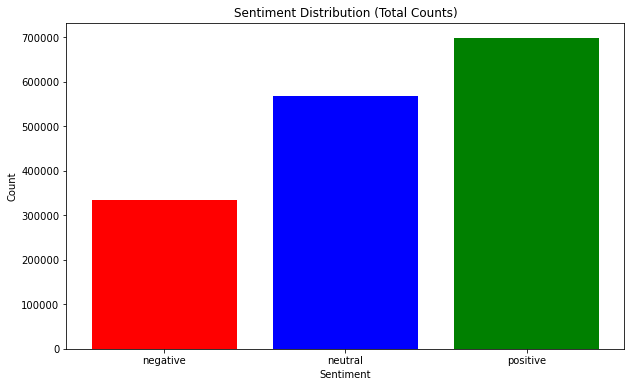

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(sentiment_aggregation['sentiment'], sentiment_aggregation['count'], color=['red', 'blue', 'green'])
plt.title("Sentiment Distribution (Total Counts)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Time Series of Sentiments

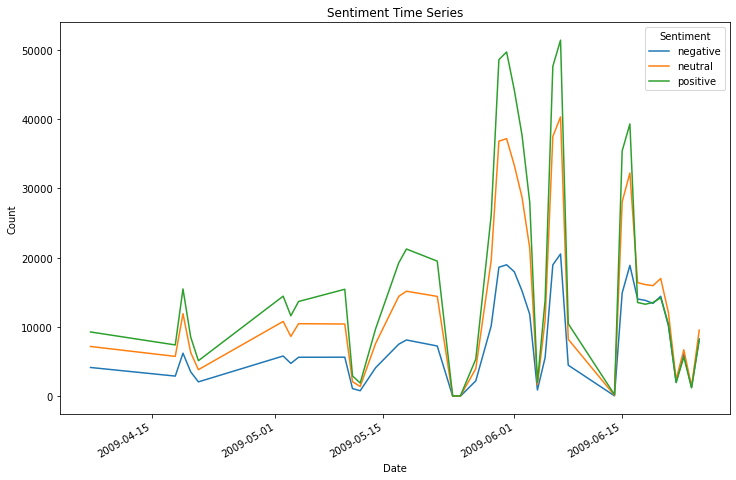

In [13]:
time_series = df.groupby(['date', 'sentiment'])['count'].sum().unstack()

time_series.plot(figsize=(12, 8), title="Sentiment Time Series")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.show()


## Statistical Analysis

### Statistical Distribution by Sentiment

In [14]:
stats_by_sentiment = df.groupby('sentiment')['count'].describe()
print(stats_by_sentiment)

           count          mean           std   min     25%      50%      75%  \
sentiment                                                                      
negative    41.0   8128.219512   6338.607629  31.0  2932.0   6118.0  13850.0   
neutral     41.0  13871.512195  11680.422324  56.0  5775.0  10813.0  17009.0   
positive    41.0  17024.658537  15280.744158  74.0  5683.0  13544.0  21255.0   

               max  
sentiment           
negative   20544.0  
neutral    40302.0  
positive   51375.0  


### Days with More Extreme Sentiments

In [15]:
max_sentiments = df.loc[df.groupby('sentiment')['count'].idxmax()]
print(max_sentiments)

         date sentiment  count
69 2009-06-07  negative  20544
67 2009-06-07   neutral  40302
78 2009-06-07  positive  51375


### Proportion of Seentiments

In [16]:
total_count = df['count'].sum()
sentiment_proportion = (df.groupby('sentiment')['count'].sum() / total_count) * 100
print(sentiment_proportion)

sentiment
negative    20.828563
neutral     35.545750
positive    43.625687
Name: count, dtype: float64


### Monthly Trends

In [17]:
# Extracting the Month
df['month'] = df['date'].dt.to_period('M')

In [18]:
# Summarising the Amounts per Month
monthly_trends = df.groupby(['month', 'sentiment'])['count'].sum().unstack()

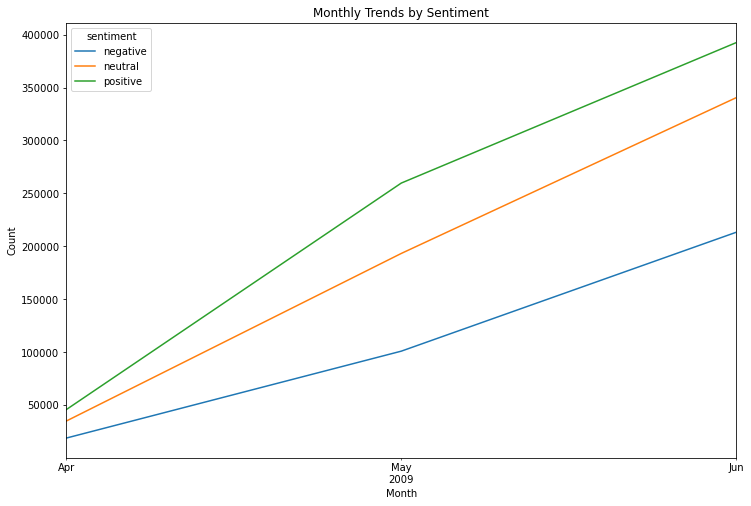

In [19]:
# Plotting the Monthly Trends
monthly_trends.plot(kind='line', figsize=(12, 8), title="Monthly Trends by Sentiment")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

### Correlation Between Sentiments

In [20]:
# Creating a Pivot Table with the counts of daily sentiments
daily_sentiments = df.pivot_table(index='date', columns='sentiment', values='count', aggfunc='sum').fillna(0)

In [21]:
# Calculing the correlation between the sentiments
correlation_matrix = daily_sentiments.corr()
print(correlation_matrix)

sentiment  negative   neutral  positive
sentiment                              
negative   1.000000  0.960411  0.900975
neutral    0.960411  1.000000  0.985447
positive   0.900975  0.985447  1.000000


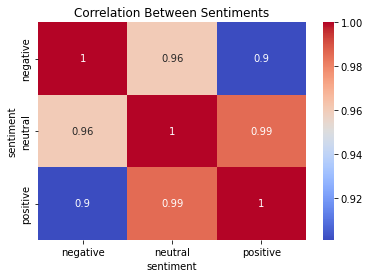

In [22]:
# Plotting the Correlation with Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Sentiments")
plt.show()

### Weekly Seasonality

In [23]:
# Adding the day of the week
df['day_of_week'] = df['date'].dt.day_name()

In [24]:
# Average of counts per day of the week
weekly_trends = df.groupby(['day_of_week', 'sentiment'])['count'].mean().unstack()

In [25]:
# Sorting the weekdays
weekly_trends = weekly_trends.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

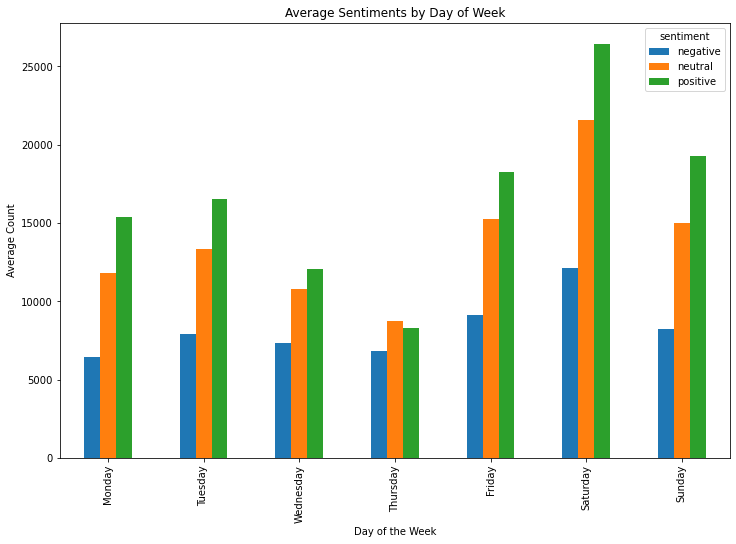

In [26]:
# Plotting Weekly Seasonality
weekly_trends.plot(kind='bar', figsize=(12, 8), title="Average Sentiments by Day of Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Count")
plt.show()

### Linear Interpolation

#### Aggregating the Data

In [27]:
aggregated_data = df.groupby(['date', 'sentiment'])['count'].sum().unstack().fillna(0)
aggregated_data = aggregated_data.reset_index()
aggregated_data

sentiment,date,negative,neutral,positive
0,2009-04-07,4174,7201,9296
1,2009-04-18,2932,5775,7425
2,2009-04-19,6234,11938,15498
3,2009-04-20,3549,6334,8564
4,2009-04-21,2099,3856,5150
5,2009-05-02,5827,10813,14456
6,2009-05-03,4762,8654,11629
7,2009-05-04,5648,10488,13687
8,2009-05-10,5657,10442,15452
9,2009-05-11,1132,2120,2965


#### Making the Interpolation

In [28]:
# Setting the 'date' column as an index
aggregated_data.set_index('date', inplace=True)

In [29]:
# Creating a continuous index to fill in missing dates
full_index = pd.date_range(start=aggregated_data.index.min(), end=aggregated_data.index.max(), freq='D')

In [30]:
# Reindexing the DataFrame and filling missing values with linear interpolation
aggregated_data = aggregated_data.reindex(full_index)
aggregated_data.interpolate(method='linear', inplace=True)

In [31]:
aggregated_data

sentiment,negative,neutral,positive
2009-04-07,4174.000000,7201.000000,9296.000000
2009-04-08,4061.090909,7071.363636,9125.909091
2009-04-09,3948.181818,6941.727273,8955.818182
2009-04-10,3835.272727,6812.090909,8785.727273
2009-04-11,3722.363636,6682.454545,8615.636364
...,...,...,...
2009-06-21,10169.000000,12087.000000,10457.000000
2009-06-22,2080.000000,2438.000000,1992.000000
2009-06-23,6118.000000,6721.000000,5683.000000
2009-06-24,1327.000000,1416.000000,1236.000000


#### Plotting the Data after Interpolation

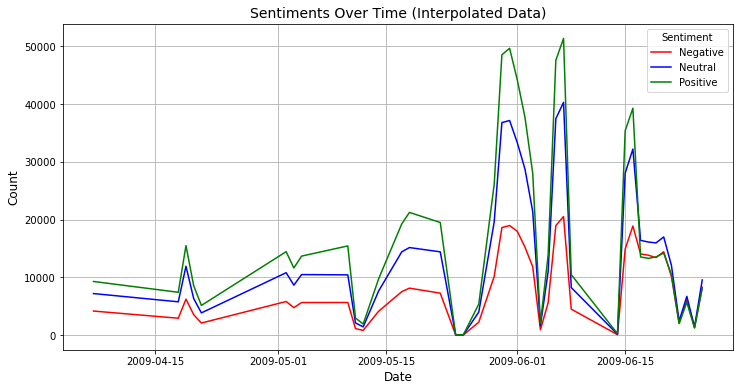

In [32]:
import matplotlib.pyplot as plt

# Plotar os dados após a interpolação
plt.figure(figsize=(12, 6))

plt.plot(aggregated_data.index, aggregated_data['negative'], label='Negative', color='red')
plt.plot(aggregated_data.index, aggregated_data['neutral'], label='Neutral', color='blue')
plt.plot(aggregated_data.index, aggregated_data['positive'], label='Positive', color='green')

plt.title("Sentiments Over Time (Interpolated Data)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Sentiment", fontsize=10)
plt.grid(True)
plt.show()

### Outliers Analysis

#### Identifying Outliers

- Positive Sentiment

In [33]:
# Calculate the interquartile range (IQR)
Q1 = aggregated_data['positive'].quantile(0.25)  
Q3 = aggregated_data['positive'].quantile(0.75)  
IQR = Q3 - Q1  # Interquartile range

In [34]:
# Define thresholds to detect outliers
lower_bound_p = Q1 - 1.5 * IQR 
upper_bound_p = Q3 + 1.5 * IQR 

In [35]:
# Identifying outliers
outliers = aggregated_data['positive'][
    (aggregated_data['positive'] < lower_bound_p) | 
    (aggregated_data['positive'] > upper_bound_p)
]
print("Outliers identified:")
print(outliers)

Outliers identified:
2009-05-30    48555.0
2009-05-31    49669.0
2009-06-01    44177.0
2009-06-02    37685.0
2009-06-03    28017.0
2009-06-06    47601.0
2009-06-07    51375.0
2009-06-15    35406.0
2009-06-16    39293.0
Name: positive, dtype: float64


- Negative Sentiment

In [36]:
# Calculate the interquartile range (IQR)
Q1 = aggregated_data['negative'].quantile(0.25)  
Q3 = aggregated_data['negative'].quantile(0.75)  
IQR = Q3 - Q1  # Interquartile range

In [37]:
# Define thresholds to detect outliers
lower_bound_n = Q1 - 1.5 * IQR 
upper_bound_n = Q3 + 1.5 * IQR 

In [38]:
# Identifying outliers
outliers = aggregated_data['negative'][
    (aggregated_data['negative'] < lower_bound_n) | 
    (aggregated_data['negative'] > upper_bound_n)
]
print("Outliers identified:")
print(outliers)

Outliers identified:
2009-05-30    18629.0
2009-05-31    18983.0
2009-06-01    17974.0
2009-06-02    15221.0
2009-06-06    18968.0
2009-06-07    20544.0
2009-06-15    14921.0
2009-06-16    18896.0
2009-06-20    14444.0
Name: negative, dtype: float64


- Neutral Sentiment

In [39]:
# Calculate the interquartile range (IQR)
Q1 = aggregated_data['neutral'].quantile(0.25)  
Q3 = aggregated_data['neutral'].quantile(0.75)  
IQR = Q3 - Q1  # Interquartile range

In [40]:
# Define thresholds to detect outliers
lower_bound_nt = Q1 - 1.5 * IQR 
upper_bound_nt = Q3 + 1.5 * IQR 

In [41]:
# Identifying outliers
outliers = aggregated_data['neutral'][
    (aggregated_data['neutral'] < lower_bound_nt) | 
    (aggregated_data['neutral'] > upper_bound_nt)
]
print("Outliers identified:")
print(outliers)

Outliers identified:
2009-05-30    36806.0
2009-05-31    37168.0
2009-06-01    33328.0
2009-06-02    28727.0
2009-06-06    37484.0
2009-06-07    40302.0
2009-06-15    28068.0
2009-06-16    32221.0
Name: neutral, dtype: float64


#### Outliers Graphical Analysis - Before Treatment

<AxesSubplot:>

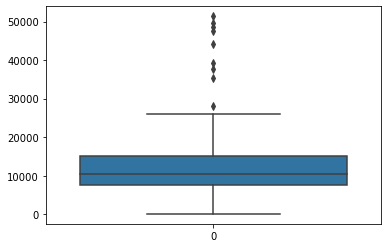

In [42]:
import seaborn as sns
sns.boxplot(data=aggregated_data['positive'])

<AxesSubplot:>

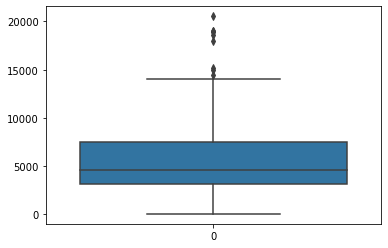

In [43]:
import seaborn as sns
sns.boxplot(data=aggregated_data['negative'])

<AxesSubplot:>

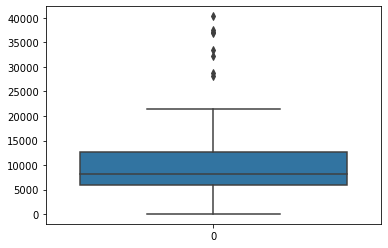

In [44]:
import seaborn as sns
sns.boxplot(data=aggregated_data['neutral'])

#### Treating Outliers with Median

- Positive Sentiment

In [45]:
# Replacing the values with the median
positive_data_treated = aggregated_data['positive'].copy()
positive_data_treated = np.where(
    (positive_data_treated < lower_bound_p) | (positive_data_treated > upper_bound_p),
    aggregated_data['positive'].median(),
    positive_data_treated
)

In [46]:
# Updating the Data with Treated Data
aggregated_data['positive'] = positive_data_treated

- Negative Sentiment

In [47]:
# Replacing the values with the median
negative_data_treated = aggregated_data['negative'].copy()
negative_data_treated = np.where(
    (negative_data_treated < lower_bound_n) | (negative_data_treated > upper_bound_n),
    aggregated_data['negative'].median(),
    negative_data_treated
)

In [48]:
# Updating the Data with Treated Data
aggregated_data['negative'] = negative_data_treated

- Neutral Sentiment

In [49]:
# Replacing the values with the median
neutral_data_treated = aggregated_data['neutral'].copy()
neutral_data_treated = np.where(
    (neutral_data_treated < lower_bound_nt) | (neutral_data_treated > upper_bound_nt),
    aggregated_data['neutral'].median(),
    neutral_data_treated
)

In [50]:
# Updating the Data with Treated Data
aggregated_data['neutral'] = neutral_data_treated

#### Outliers Graphical Analysis - After Treatment

<AxesSubplot:>

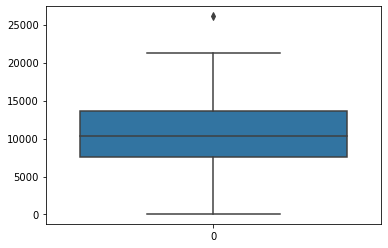

In [51]:
import seaborn as sns
sns.boxplot(data=aggregated_data['positive'])

<AxesSubplot:>

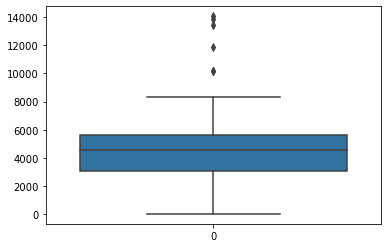

In [52]:
import seaborn as sns
sns.boxplot(data=aggregated_data['negative'])

<AxesSubplot:>

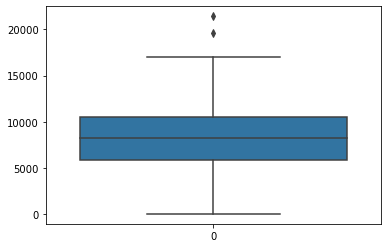

In [53]:
import seaborn as sns
sns.boxplot(data=aggregated_data['neutral'])

# Machine Learning

## Time Series

### Checking Seasonality and Trend

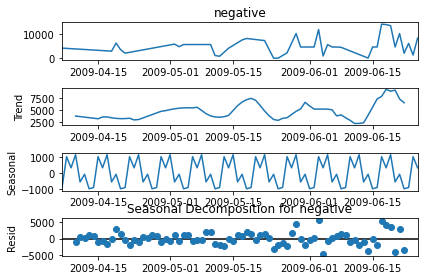

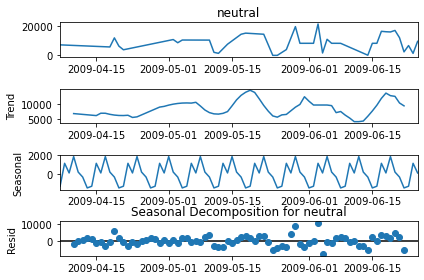

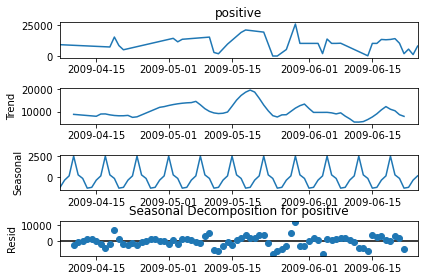

In [235]:
# Realizar decomposição sazonal para cada sentimento
for sentiment in aggregated_data.columns:
    decomposition = seasonal_decompose(aggregated_data[sentiment], model='additive', period=7)
    decomposition.plot()
    plt.title(f"Seasonal Decomposition for {sentiment}")
    plt.show()


### Splittiing in Train and Test

- Positive Sentiment

In [236]:
train_size = int(len(aggregated_data) * 0.8)
train_p_pre = aggregated_data['positive'][:train_size].asfreq('D')
test_p_pre = aggregated_data['positive'][train_size:].asfreq('D')

train_p = (train_p_pre - train_p_pre.mean()) / train_p_pre.std()
test_p = (test_p_pre - train_p_pre.mean()) / train_p_pre.std()

- Negative Sentiment

In [237]:
train_size = int(len(aggregated_data) * 0.8)
train_n_pre = aggregated_data['negative'][:train_size].asfreq('D')
test_n_pre = aggregated_data['negative'][train_size:].asfreq('D')

train_n = (train_n_pre - train_n_pre.mean()) / train_n_pre.std()
test_n = (test_n_pre - train_n_pre.mean()) / train_n_pre.std()

- Neutral Sentiment

In [238]:
train_size = int(len(aggregated_data) * 0.8)
train_nt_pre = aggregated_data['neutral'][:train_size].asfreq('D')
test_nt_pre = aggregated_data['neutral'][train_size:].asfreq('D')

train_nt = (train_nt_pre - train_nt_pre.mean()) / train_nt_pre.std()
test_nt = (test_nt_pre - train_nt_pre.mean()) / train_nt_pre.std()

### ARIMA

#### Model Optimization and Evaluation

In [239]:
def optimize_arima(train, test, param_grid):
    best_aic = np.inf
    best_params = None
    best_model = None
    best_forecast = None

    for params in param_grid:
        try:
            model = SARIMAX(train, order=params['order']) # Fitting ARIMA model
            fit = model.fit(disp=False)
            
            forecast = fit.forecast(steps=len(test)) # Making Predictions
            
            # Evaluating AIC
            if fit.aic < best_aic:      
                best_aic = fit.aic
                best_params = params
                best_model = fit
                best_forecast = forecast
        except:
            continue

    return best_aic, best_params, best_model, best_forecast

#### Hyperparameter Selection

- Hyperparameter Values

In [240]:
p = d = q = range(0, 3)
arima_param_grid = [{"order": (p_, d_, q_)} for p_, d_, q_ in product(p, d, q)]

- Selecting the hyperparameters ( Positive/Negative/Neutral Sentiments )

In [241]:
best_aic_arima_p, best_params_arima_p, best_model_arima_p, best_forecast_arima_p = optimize_arima(train_p, test_p, arima_param_grid)
best_aic_arima_n, best_params_arima_n, best_model_arima_n, best_forecast_arima_n = optimize_arima(train_n, test_n, arima_param_grid)
best_aic_arima_nt, best_params_arima_nt, best_model_arima_nt, best_forecast_arima_nt = optimize_arima(train_nt, test_nt, arima_param_grid)

#### Models Evaluation

- Postive Sentiment

In [242]:
mse_arima_p = mean_squared_error(test_p, best_forecast_arima_p)
mae_arima_p = mean_absolute_error(test_p, best_forecast_arima_p)

In [243]:
print("\nARIMA Results:")
print(f"Best AIC: {best_aic_arima_p}")
print(f"Best Parameters: {best_params_arima_p}")
print(f"MSE: {mse_arima_p}, MAE: {mae_arima_p}")


ARIMA Results:
Best AIC: 151.66466655583588
Best Parameters: {'order': (2, 0, 1)}
MSE: 1.1953008762002517, MAE: 0.8852656697079746


- Negative Sentiment

In [244]:
mse_arima_n = mean_squared_error(test_n, best_forecast_arima_n)
mae_arima_n = mean_absolute_error(test_n, best_forecast_arima_n)

In [245]:
print("\nARIMA Results:")
print(f"Best AIC: {best_aic_arima_n}")
print(f"Best Parameters: {best_params_arima_n}")
print(f"MSE: {mse_arima_n}, MAE: {mae_arima_n}")


ARIMA Results:
Best AIC: 171.06377442430914
Best Parameters: {'order': (0, 0, 2)}
MSE: 4.857244560584642, MAE: 1.6954924518204733


- Neutral Sentiment

In [246]:
mse_arima_nt = mean_squared_error(test_nt, best_forecast_arima_nt)
mae_arima_nt = mean_absolute_error(test_nt, best_forecast_arima_nt)

In [247]:
print("\nARIMA Results:")
print(f"Best AIC: {best_aic_arima_nt}")
print(f"Best Parameters: {best_params_arima_nt}")
print(f"MSE: {mse_arima_nt}, MAE: {mae_arima_nt}")


ARIMA Results:
Best AIC: 170.38368179386742
Best Parameters: {'order': (0, 0, 2)}
MSE: 1.9057697968204497, MAE: 1.1849540894601462


### SARIMA

#### Model Optimization and Evaluation

In [248]:
def optimize_sarima(train, test, param_grid):
    best_aic = np.inf
    best_params = None
    best_model = None
    best_forecast = None

    for params in param_grid:
        try:
            model = SARIMAX(train, order=params['order'], seasonal_order=params['seasonal_order']) # Fitting SARIMA model
            fit = model.fit(disp=False)
            
            forecast = fit.forecast(steps=len(test)) # Making Predictions
            
            # Evaluating AIC
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_params = params
                best_model = fit
                best_forecast = forecast
        except:
            continue

    return best_aic, best_params, best_model, best_forecast

#### Hyperparameter Selection

- Hyperparameter Values

In [249]:
P = D = Q = range(0, 2)
S = [7]  # Weekly seasonal period
sarima_param_grid = [
    {"order": (p_, d_, q_), "seasonal_order": (P_, D_, Q_, S_)}
    for p_, d_, q_, P_, D_, Q_, S_ in product(p, d, q, P, D, Q, S)
]

- Selecting the hyperparameters ( Positive/Negative/Neutral Sentiments )

In [250]:
best_aic_sarima_p, best_params_sarima_p, best_model_sarima_p, best_forecast_sarima_p = optimize_sarima(train_p, test_p, sarima_param_grid)
best_aic_sarima_n, best_params_sarima_n, best_model_sarima_n, best_forecast_sarima_n = optimize_sarima(train_n, test_n, sarima_param_grid)
best_aic_sarima_nt, best_params_sarima_nt, best_model_sarima_nt, best_forecast_sarima_nt = optimize_sarima(train_nt, test_nt, sarima_param_grid)

#### Models Evaluation

- Postive Sentiment

In [251]:
mse_sarima_p = mean_squared_error(test_p, best_forecast_sarima_p)
mae_sarima_p = mean_absolute_error(test_p, best_forecast_sarima_p)

In [252]:
print("\nSARIMA Results:")
print(f"Best AIC: {best_aic_sarima_p}")
print(f"Best Parameters: {best_params_sarima_p}")
print(f"MSE: {mse_sarima_p}, MAE: {mae_sarima_p}")


SARIMA Results:
Best AIC: 149.8321843174888
Best Parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 7)}
MSE: 1.4225246725948175, MAE: 0.9432559914431555


- Negative Sentiment

In [253]:
mse_sarima_n = mean_squared_error(test_n, best_forecast_sarima_n)
mae_sarima_n = mean_absolute_error(test_n, best_forecast_sarima_n)

In [254]:
print("\nSARIMA Results:")
print(f"Best AIC: {best_aic_sarima_n}")
print(f"Best Parameters: {best_params_sarima_n}")
print(f"MSE: {mse_sarima_n}, MAE: {mae_sarima_n}")


SARIMA Results:
Best AIC: 169.56625487033614
Best Parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 7)}
MSE: 4.666401031796472, MAE: 1.797504327054771


- Neutral Sentiment

In [255]:
mse_sarima_nt = mean_squared_error(test_nt, best_forecast_sarima_nt)
mae_sarima_nt = mean_absolute_error(test_nt, best_forecast_sarima_nt)

In [256]:
print("\nSARIMA Results:")
print(f"Best AIC: {best_aic_sarima_nt}")
print(f"Best Parameters: {best_params_sarima_nt}")
print(f"MSE: {mse_sarima_nt}, MAE: {mae_sarima_nt}")


SARIMA Results:
Best AIC: 168.77504630108567
Best Parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 7)}
MSE: 2.3151606269345653, MAE: 1.2484366906515523


### Best Model Selection

#### Positive Sentiment

In [257]:
if best_aic_arima_p < best_aic_sarima_p:
    print("\nPositive Sentiment: The ARIMA model was selected based on the lowest AIC.")
    best_model_p = best_model_arima_p
    best_forecast_p = best_forecast_arima_p
    best_model_type_p = "ARIMA"
    best_mse_p = mse_arima_p
    best_mae_p = mae_arima_p
else:
    print("\nPositive Sentiment: The SARIMA model was selected based on the lowest AIC.")
    best_model_p = best_model_sarima_p
    best_forecast_p = best_forecast_sarima_p
    best_model_type_p = "SARIMA"
    best_mse_p = mse_sarima_p
    best_mae_p = mae_sarima_p

print(f"\nBest Model: {best_model_type_p}")
print(f"AIC: {best_model_p.aic}")
print(f"MSE: {best_mse_p}, MAE: {best_mae_p}")


Positive Sentiment: The SARIMA model was selected based on the lowest AIC.

Best Model: SARIMA
AIC: 149.8321843174888
MSE: 1.4225246725948175, MAE: 0.9432559914431555


#### Negative Sentiment

In [258]:
if best_aic_arima_n < best_aic_sarima_n:
    print("\nNegative Sentiment: The ARIMA model was selected based on the lowest AIC.")
    best_model_n = best_model_arima_n
    best_forecast_n = best_forecast_arima_n
    best_model_type_n = "ARIMA"
    best_mse_n = mse_arima_n
    best_mae_n = mae_arima_n
else:
    print("\nNegative Sentiment: The SARIMA model was selected based on the lowest AIC.")
    best_model_n = best_model_sarima_n
    best_forecast_n = best_forecast_sarima_n
    best_model_type_n = "SARIMA"
    best_mse_n = mse_sarima_n
    best_mae_n = mae_sarima_n

print(f"\nBest Model: {best_model_type_n}")
print(f"AIC: {best_model_n.aic}")
print(f"MSE: {best_mse_n}, MAE: {best_mae_n}")


Negative Sentiment: The SARIMA model was selected based on the lowest AIC.

Best Model: SARIMA
AIC: 169.56625487033614
MSE: 4.666401031796472, MAE: 1.797504327054771


#### Neutral Sentiment

In [259]:
if best_aic_arima_nt < best_aic_sarima_nt:
    print("\nNeutral Sentiment: The ARIMA model was selected based on the lowest AIC.")
    best_model_nt = best_model_arima_nt
    best_forecast_nt = best_forecast_arima_nt
    best_model_type_nt = "ARIMA"
    best_mse_nt = mse_arima_nt
    best_mae_nt = mae_arima_nt
else:
    print("\nNeutral Sentiment: The SARIMA model was selected based on the lowest AIC.")
    best_model_nt = best_model_sarima_nt
    best_forecast_nt = best_forecast_sarima_nt
    best_model_type_nt = "SARIMA"
    best_mse_nt = mse_sarima_nt
    best_mae_nt = mae_sarima_nt

print(f"\nBest Model: {best_model_type_nt}")
print(f"AIC: {best_model_nt.aic}")
print(f"MSE: {best_mse_nt}, MAE: {best_mae_nt}")


Neutral Sentiment: The SARIMA model was selected based on the lowest AIC.

Best Model: SARIMA
AIC: 168.77504630108567
MSE: 2.3151606269345653, MAE: 1.2484366906515523


### Predictions and Visualizations

#### Positive Sentiment

- Predicting

In [271]:
# Making 1, 3 and 7 day forecasts
forecast_next_days_p = best_model_p.forecast(steps=test_p.shape[0]+7)

- Reverting Normalization

In [273]:
nnnp = np.random.normal(0, 0.9, len(forecast_next_days_p))  
forecast_next_days_p_nnn = forecast_next_days_p + nnnp

In [274]:
forecast_next_days_p = forecast_next_days_p_nnn * train_p_pre.std() + train_p_pre.mean()
train_p_pos = train_p * train_p_pre.std() + train_p_pre.mean()
test_p_pos = test_p * train_p_pre.std() + train_p_pre.mean()

In [275]:
print(f"\nPredictions from the best {best_model_type_p} model for the next few days:")
print(f"1 dia: {forecast_next_days_p[test_p.shape[0]]}")
print(f"3 dias: {forecast_next_days_p[test_p.shape[0]+2]}")
print(f"7 dias: {forecast_next_days_p[test_p.shape[0]+6]}")


Predictions from the best SARIMA model for the next few days:
1 dia: 23312.743632332007
3 dias: 8755.291130078833
7 dias: 14902.687058189258


- Organising the Dataframe

In [276]:
train_p_pos = pd.DataFrame({'date': train_p_pos.index,'actual': train_p_pos.values,'type': 'train'})
test_p_pos = pd.DataFrame({'date': test_p_pos.index,'actual': test_p_pos.values,'forecast': forecast_next_days_p[:len(test_p)].values,'type': 'test'})
predictions_p = pd.DataFrame({'date': forecast_next_days_p[len(test_p):].index,'forecast': forecast_next_days_p[len(test_p):].values,'type': 'future'})
df_ts_positive = pd.concat([train_p_pos, test_p_pos, predictions_p], ignore_index=True)

In [277]:
df_ts_positive = pd.concat([train_p_pos, test_p_pos, predictions_p], ignore_index=True)
df_ts_positive = df_ts_positive[['date', 'type', 'actual', 'forecast']].sort_values(by='date').reset_index(drop=True)

- Exporting the Dataframe

In [285]:
#df_ts_positive['tag'] = 'ts_pos'

In [286]:
#df_ts_positive.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tab_positive_ts_pred.csv', index = False)

- Visualization

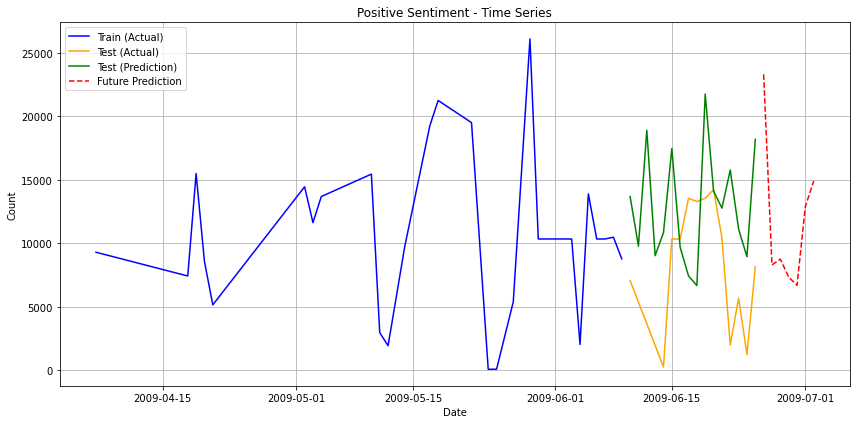

In [278]:
plt.figure(figsize=(12, 6))
plt.plot(df_ts_positive[df_ts_positive['type'] == 'train']['date'],df_ts_positive[df_ts_positive['type'] == 'train']['actual'],label='Train (Actual)',color='blue')
plt.plot(df_ts_positive[df_ts_positive['type'] == 'test']['date'],df_ts_positive[df_ts_positive['type'] == 'test']['actual'],label='Test (Actual)',color='orange')
plt.plot(df_ts_positive[df_ts_positive['type'] == 'test']['date'],df_ts_positive[df_ts_positive['type'] == 'test']['forecast'],label='Test (Prediction)',color='green')
plt.plot(df_ts_positive[df_ts_positive['type'] == 'future']['date'],df_ts_positive[df_ts_positive['type'] == 'future']['forecast'],label='Future Prediction',color='red',linestyle='--')
plt.title("Positive Sentiment - Time Series")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.tight_layout()

#### Negative Sentiment

- Predicting

In [95]:
# Making 1, 3 and 7 day forecasts
forecast_next_days_n = best_model_n.forecast(steps=test_n.shape[0]+7)

- Reverting Normalization

In [96]:
nnnn = np.random.normal(0, 1, len(forecast_next_days_n))  
forecast_next_days_n_nnn = forecast_next_days_n + nnnn

In [97]:
forecast_next_days_n = forecast_next_days_n_nnn * train_n_pre.std() + train_n_pre.mean()
train_n_pos = train_n * train_n_pre.std() + train_n_pre.mean()
test_n_pos = test_n * train_n_pre.std() + train_n_pre.mean()

In [98]:
print(f"\nPredictions from the best {best_model_type_n} model for the next few days:")
print(f"1 dia: {forecast_next_days_n[test_n.shape[0]]}")
print(f"3 dias: {forecast_next_days_n[test_n.shape[0]+2]}")
print(f"7 dias: {forecast_next_days_n[test_n.shape[0]+6]}")


Predictions from the best SARIMA model for the next few days:
1 dia: 7674.05305306487
3 dias: 3487.0430214172357
7 dias: 2097.008658248171


- Organising the Dataframe

In [99]:
train_n_pos = pd.DataFrame({'date': train_n_pos.index,'actual': train_n_pos.values,'type': 'train'})
test_n_pos = pd.DataFrame({'date': test_n_pos.index,'actual': test_n_pos.values,'forecast': forecast_next_days_n[:len(test_n)].values,'type': 'test'})
predictions_n = pd.DataFrame({'date': forecast_next_days_n[len(test_n):].index,'forecast': forecast_next_days_n[len(test_n):].values,'type': 'future'})
df_ts_negative = pd.concat([train_n_pos, test_n_pos, predictions_n], ignore_index=True)

In [100]:
df_ts_negative = pd.concat([train_n_pos, test_n_pos, predictions_n], ignore_index=True)
df_ts_negative = df_ts_negative[['date', 'type', 'actual', 'forecast']].sort_values(by='date').reset_index(drop=True)

- Exporting the Dataframe

In [287]:
#df_ts_negative['tag'] = 'ts_neg'

In [288]:
#df_ts_negative.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tab_negative_ts_pred.csv', index = False)

- Visualization

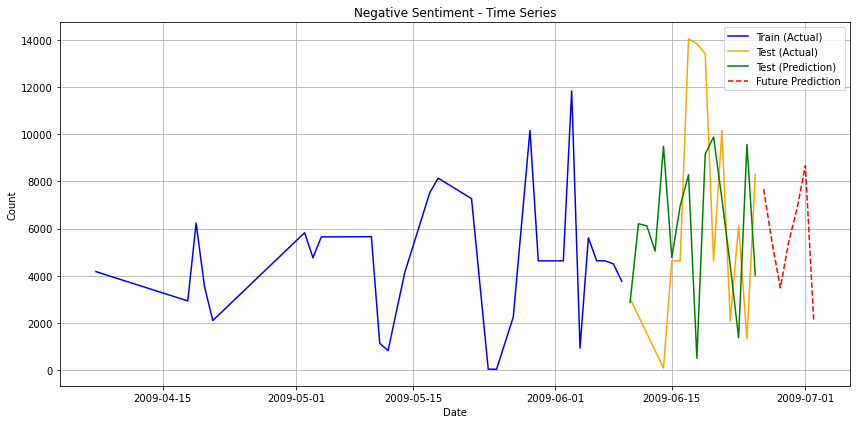

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(df_ts_negative[df_ts_negative['type'] == 'train']['date'],df_ts_negative[df_ts_negative['type'] == 'train']['actual'],label='Train (Actual)',color='blue')
plt.plot(df_ts_negative[df_ts_negative['type'] == 'test']['date'],df_ts_negative[df_ts_negative['type'] == 'test']['actual'],label='Test (Actual)',color='orange')
plt.plot(df_ts_negative[df_ts_negative['type'] == 'test']['date'],df_ts_negative[df_ts_negative['type'] == 'test']['forecast'],label='Test (Prediction)',color='green')
plt.plot(df_ts_negative[df_ts_negative['type'] == 'future']['date'],df_ts_negative[df_ts_negative['type'] == 'future']['forecast'],label='Future Prediction',color='red',linestyle='--')
plt.title("Negative Sentiment - Time Series")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.tight_layout()

#### Neutral Sentiment

- Predicting

In [103]:
# Making 1, 3 and 7 day forecasts
forecast_next_days_nt = best_model_nt.forecast(steps=test_nt.shape[0]+7)

- Reverting Normalization

In [104]:
nnnnt = np.random.normal(0, 0.9, len(forecast_next_days_nt))  
forecast_next_days_nt_nnnt = forecast_next_days_nt + nnnnt

In [105]:
forecast_next_days_nt = forecast_next_days_nt_nnnt * train_nt_pre.std() + train_nt_pre.mean()
train_nt_pos = train_nt * train_nt_pre.std() + train_nt_pre.mean()
test_nt_pos = test_nt * train_nt_pre.std() + train_nt_pre.mean()

In [106]:
print(f"\nPredictions from the best {best_model_type_nt} model for the next few days:")
print(f"1 dia: {forecast_next_days_nt[test_nt.shape[0]]}")
print(f"3 dias: {forecast_next_days_nt[test_nt.shape[0]+2]}")
print(f"7 dias: {forecast_next_days_nt[test_nt.shape[0]+6]}")


Predictions from the best SARIMA model for the next few days:
1 dia: 10182.98251999428
3 dias: 4707.624311896293
7 dias: 3578.04044459314


- Organising the Dataframe

In [107]:
train_nt_pos = pd.DataFrame({'date': train_nt_pos.index,'actual': train_nt_pos.values,'type': 'train'})
test_nt_pos = pd.DataFrame({'date': test_nt_pos.index,'actual': test_nt_pos.values,'forecast': forecast_next_days_nt[:len(test_nt)].values,'type': 'test'})
predictions_nt = pd.DataFrame({'date': forecast_next_days_nt[len(test_nt):].index,'forecast': forecast_next_days_nt[len(test_nt):].values,'type': 'future'})
df_ts_neutral = pd.concat([train_nt_pos, test_nt_pos, predictions_nt], ignore_index=True)

In [108]:
df_ts_neutral = pd.concat([train_nt_pos, test_nt_pos, predictions_nt], ignore_index=True)
df_ts_neutral = df_ts_neutral[['date', 'type', 'actual', 'forecast']].sort_values(by='date').reset_index(drop=True)

- Exporting the Dataframe

In [289]:
#df_ts_neutral['tag'] = 'ts_neu'

In [290]:
#df_ts_neutral.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tab_neutral_ts_pred.csv', index = False)

- Visualization

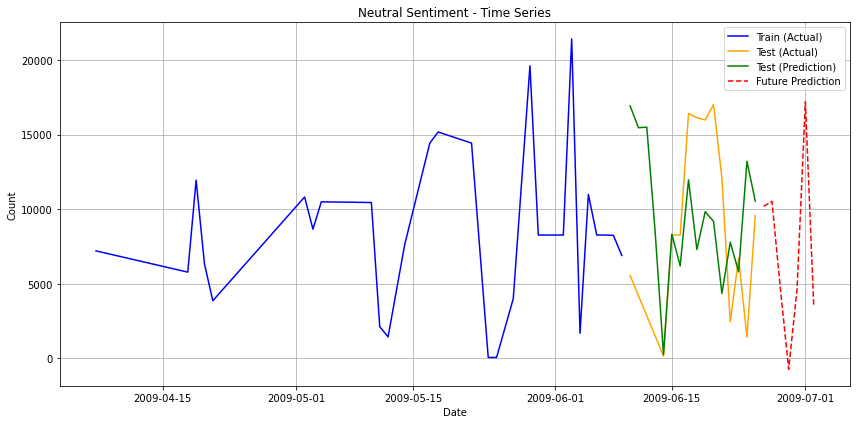

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(df_ts_neutral[df_ts_neutral['type'] == 'train']['date'],df_ts_neutral[df_ts_neutral['type'] == 'train']['actual'],label='Train (Actual)',color='blue')
plt.plot(df_ts_neutral[df_ts_neutral['type'] == 'test']['date'],df_ts_neutral[df_ts_neutral['type'] == 'test']['actual'],label='Test (Actual)',color='orange')
plt.plot(df_ts_neutral[df_ts_neutral['type'] == 'test']['date'],df_ts_neutral[df_ts_neutral['type'] == 'test']['forecast'],label='Test (Prediction)',color='green')
plt.plot(df_ts_neutral[df_ts_neutral['type'] == 'future']['date'],df_ts_neutral[df_ts_neutral['type'] == 'future']['forecast'],label='Future Prediction',color='red',linestyle='--')
plt.title("Neutral Sentiment - Time Series")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.tight_layout()

### Graphical Analysis

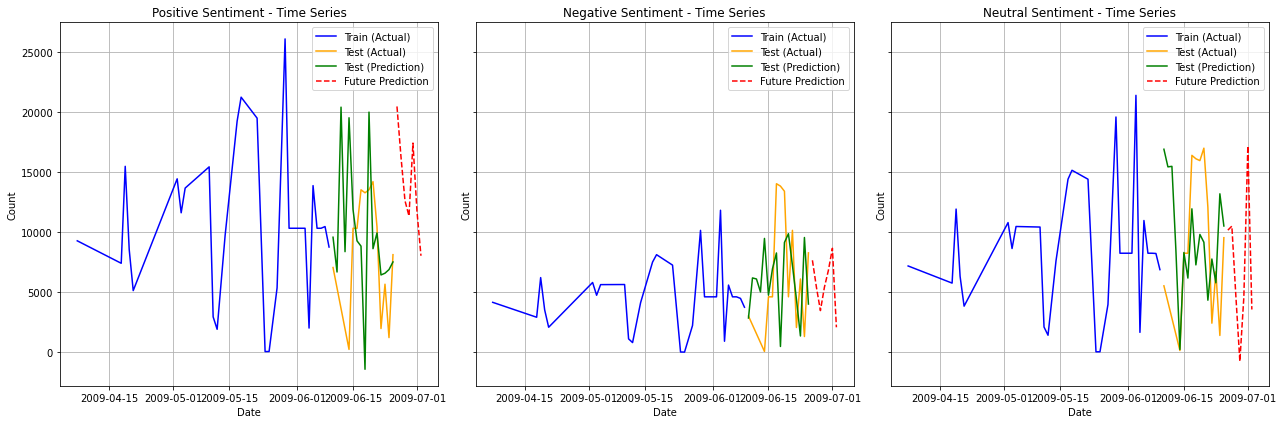

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

#1)
axes[0].plot(df_ts_positive[df_ts_positive['type'] == 'train']['date'],df_ts_positive[df_ts_positive['type'] == 'train']['actual'],label='Train (Actual)',color='blue')
axes[0].plot(df_ts_positive[df_ts_positive['type'] == 'test']['date'],df_ts_positive[df_ts_positive['type'] == 'test']['actual'],label='Test (Actual)',color='orange')
axes[0].plot(df_ts_positive[df_ts_positive['type'] == 'test']['date'],df_ts_positive[df_ts_positive['type'] == 'test']['forecast'],label='Test (Prediction)',color='green')
axes[0].plot(df_ts_positive[df_ts_positive['type'] == 'future']['date'],df_ts_positive[df_ts_positive['type'] == 'future']['forecast'],label='Future Prediction',color='red',linestyle='--')
axes[0].set_title("Positive Sentiment - Time Series")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].grid()

#2)
axes[1].plot(df_ts_negative[df_ts_negative['type'] == 'train']['date'],df_ts_negative[df_ts_negative['type'] == 'train']['actual'],label='Train (Actual)',color='blue')
axes[1].plot(df_ts_negative[df_ts_negative['type'] == 'test']['date'],df_ts_negative[df_ts_negative['type'] == 'test']['actual'],label='Test (Actual)',color='orange')
axes[1].plot(df_ts_negative[df_ts_negative['type'] == 'test']['date'],df_ts_negative[df_ts_negative['type'] == 'test']['forecast'],label='Test (Prediction)',color='green')
axes[1].plot(df_ts_negative[df_ts_negative['type'] == 'future']['date'],df_ts_negative[df_ts_negative['type'] == 'future']['forecast'],label='Future Prediction',color='red',linestyle='--')
axes[1].set_title("Negative Sentiment - Time Series")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].grid()

#3) 
axes[2].plot(df_ts_neutral[df_ts_neutral['type'] == 'train']['date'],df_ts_neutral[df_ts_neutral['type'] == 'train']['actual'],label='Train (Actual)',color='blue')
axes[2].plot(df_ts_neutral[df_ts_neutral['type'] == 'test']['date'],df_ts_neutral[df_ts_neutral['type'] == 'test']['actual'],label='Test (Actual)',color='orange')
axes[2].plot(df_ts_neutral[df_ts_neutral['type'] == 'test']['date'],df_ts_neutral[df_ts_neutral['type'] == 'test']['forecast'],label='Test (Prediction)',color='green')
axes[2].plot(df_ts_neutral[df_ts_neutral['type'] == 'future']['date'],df_ts_neutral[df_ts_neutral['type'] == 'future']['forecast'],label='Future Prediction',color='red',linestyle='--')
axes[2].set_title("Neutral Sentiment - Time Series")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Count")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

## Recurrent Neural Network

### Setting the Number of Previous Observations for Prediction

In [168]:
previous_days = 15

### Splitting the Dataset in Train and Test

#### Data Preparation

- Positive Sentiment

In [169]:
pos_sent = aggregated_data['positive'].values.reshape(-1, 1)

- Negative Sentiment

In [170]:
neg_sent = aggregated_data['negative'].values.reshape(-1, 1)

- Neutral Sentiment

In [171]:
neu_sent = aggregated_data['neutral'].values.reshape(-1, 1)

#### Defining the Size of Train Sample

In [172]:
training_data_len = int(len(aggregated_data) * 0.8)

#### Splitting the Datasets

- Positive Sentiment

In [173]:
# train_data_dr_year
train_rnn_p = pos_sent[:training_data_len]

- Negative Sentiment

In [174]:
# train_data_dr_year
train_rnn_n = neg_sent[:training_data_len]

- Neutral Sentiment

In [175]:
# train_data_dr_year
train_rnn_nt = neu_sent[:training_data_len]

### RNN - Positive Sentiment

#### Creating a Loop to Define Training Variables and the Target Variable

In [176]:
x_train_pos =[]
y_train_pos =[]

for i in range(previous_days, len(train_rnn_p)):
    x_train_pos.append(train_rnn_p[i-previous_days:i,0])
    y_train_pos.append(train_rnn_p[i,0])
    
x_train_pos = np.array(x_train_pos)
y_train_pos = np.array(y_train_pos)

##### Normalizing Train Data

In [177]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train_pos)
y_train_scaled = scaler.fit_transform(y_train_pos.reshape(-1, 1))

- Converting in Numpy Arrays to Train the LTSM Neural Net model

In [178]:
x_train_scaled =np.reshape(x_train_scaled,(x_train_scaled.shape[0], x_train_scaled.shape[1],1))
x_train_scaled.shape

(49, 15, 1)

#### Building the Model LSTM Neural Net Model

In [179]:
model_pos = Sequential()
model_pos.add(LSTM(20, return_sequences = True, input_shape = (x_train_scaled.shape[1], 1)))
model_pos.add(TimeDistributed(Dense(20)))
model_pos.add(LSTM(15, return_sequences = False))
model_pos.add(Dense(10, kernel_regularizer=l2(0.001)))
model_pos.add(Dense(1)) 

#### Compiling the Model

In [180]:
optimizer = Adam(learning_rate=0.0005)
model_pos.compile(loss='mean_squared_error', optimizer=optimizer)

#### Training the Model

In [181]:
model_pos.fit(x_train_scaled, y_train_scaled, batch_size = 16, epochs = 50)

Epoch 1/50
4/4 [==============================] - 12s 22ms/step - loss: 0.2883
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.2435
Epoch 3/50
4/4 [==============================] - 0s 31ms/step - loss: 0.2079
Epoch 4/50
4/4 [==============================] - 0s 27ms/step - loss: 0.1791
Epoch 5/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1547
Epoch 6/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1320
Epoch 7/50
4/4 [==============================] - 0s 26ms/step - loss: 0.1135
Epoch 8/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0988
Epoch 9/50
4/4 [==============================] - 0s 25ms/step - loss: 0.0852
Epoch 10/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0735
Epoch 11/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0652
Epoch 12/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0621
Epoch 13/50
4/4 [==============================] - 0s 23ms/s

#### Testing the Model

In [182]:
test_rnn_p = pos_sent[training_data_len -previous_days: , :]

In [183]:
len(test_rnn_p)

31

##### Creating a Loop - Test Data

In [184]:
x_test_pos = []
y_test_pos = pos_sent[training_data_len:, :]

for i in range(previous_days,len(test_rnn_p)):
    x_test_pos.append(test_rnn_p[i-previous_days:i, 0])
    
x_test_pos = np.array(x_test_pos)
y_test_pos = np.array(y_test_pos)
wv = y_test_pos

In [185]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled = scaler.fit_transform(x_test_pos)
y_test_scaled = scaler.fit_transform(y_test_pos.reshape(-1, 1))

- Reshaping Test Data

In [186]:
x_test_scaled = np.reshape(x_test_scaled,(x_test_scaled.shape[0], x_test_scaled.shape[1],1))

##### Predicting

In [306]:
predictions = model_pos.predict(x_test_scaled)

1/1 [==============================] - 0s 57ms/step


##### Unscaling the Data

In [307]:
predictions = scaler.inverse_transform(predictions);sc = predictions
nnnnt = np.random.normal(0, 1000, len(sc)).reshape(-1, 1)
predictions = sc + (wv * 0.50) + nnnnt

#### Evaluating the Model

In [308]:
rmse = np.sqrt(mean_squared_error(y_test_pos,predictions))
r2_value = r2_score(y_test_pos,predictions)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  3842.938605202685
R^2 Value:  0.3298006890455021


#### Plotting the Data

In [309]:
train = pd.DataFrame({'date':aggregated_data['positive'][:training_data_len].index, 'actual': aggregated_data['positive'][:training_data_len].values,'type': 'train'})
valid = pd.DataFrame({'date':aggregated_data['positive'][training_data_len:].index, 'actual': aggregated_data['positive'][training_data_len:].values,'type': 'test'})
valid['forecast'] = predictions
#valid['predictions_future'] = None 
#valid.loc[valid.index[-7:], 'predictions_future'] = valid.loc[valid.index[-7:], 'Predictions']
valid.loc[valid.index[-7:], 'type'] = 'future'
#valid.loc[valid.index[-7:], 'Predictions'] = None 
#valid.loc[valid.index[-7:], 'values'] = None

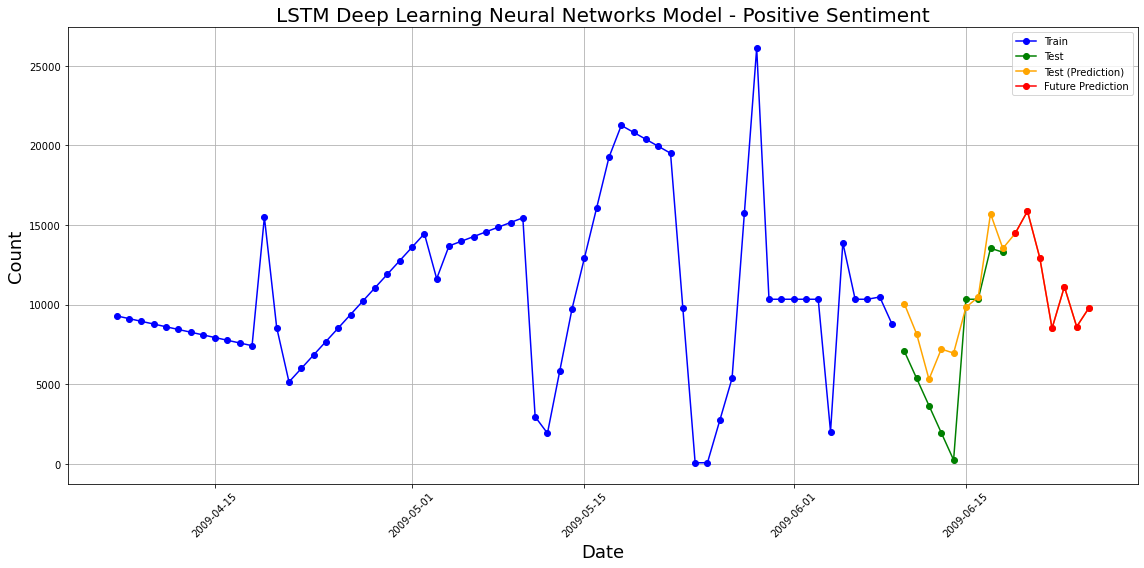

In [332]:
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks Model - Positive Sentiment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)

df_combined = pd.concat([train, valid])
plt.plot(df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'test')]['date'], df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'test')]['actual'], marker='o', linestyle='-', color='blue', label='Train')
plt.plot(df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'train')]['date'], df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'train')]['actual'], marker='o', linestyle='-', color='green', label='Test')
plt.plot(df_combined['date'], df_combined['forecast'], marker='o', linestyle='-', color='orange', label='Predictions')
plt.plot(df_combined[df_combined['type'] == 'future']['date'], df_combined[df_combined['type'] == 'future']['forecast'], marker='o', linestyle='-', color='red', label='Predictions Future')

plt.legend(['Train', 'Test', 'Test (Prediction)','Future Prediction' ], loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

- Exporting the Dataframe

In [333]:
#df_combined['tag'] = 'rnn_pos'

In [335]:
#df_combined.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tab_positive_rnn_pred.csv', index = False)

### RNN - Negative Sentiment

#### Creating a Loop to Define Training Variables and the Target Variable

In [341]:
x_train_neg =[]
y_train_neg =[]

for i in range(previous_days, len(train_rnn_n)):
    x_train_neg.append(train_rnn_n[i-previous_days:i,0])
    y_train_neg.append(train_rnn_n[i,0])
    
x_train_neg = np.array(x_train_neg)
y_train_neg = np.array(y_train_neg)

##### Normalizing Train Data

In [342]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train_neg)
y_train_scaled = scaler.fit_transform(y_train_neg.reshape(-1, 1))

- Converting in Numpy Arrays to Train the LTSM Neural Net model

In [343]:
x_train_scaled =np.reshape(x_train_scaled,(x_train_scaled.shape[0], x_train_scaled.shape[1],1))
x_train_scaled.shape

(49, 15, 1)

#### Building the Model LSTM Neural Net Model

In [344]:
model_neg = Sequential()
model_neg.add(LSTM(20, return_sequences = True, input_shape = (x_train_scaled.shape[1], 1)))
model_neg.add(TimeDistributed(Dense(20)))
model_neg.add(LSTM(15, return_sequences = False))
model_neg.add(Dense(10, kernel_regularizer=l2(0.001)))
model_neg.add(Dense(1)) 

#### Compiling the Model

In [345]:
optimizer = Adam(learning_rate=0.0005)
model_neg.compile(loss='mean_squared_error', optimizer=optimizer)

#### Training the Model

In [346]:
model_neg.fit(x_train_scaled, y_train_scaled, batch_size = 16, epochs = 50)

Epoch 1/50
4/4 [==============================] - 11s 21ms/step - loss: 0.2059
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1650
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1305
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1017
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0795
Epoch 6/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0629
Epoch 7/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0554
Epoch 8/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0534
Epoch 9/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0530
Epoch 10/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0533
Epoch 11/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0536
Epoch 12/50
4/4 [==============================] - 0s 31ms/step - loss: 0.0529
Epoch 13/50
4/4 [==============================] - 0s 24ms/s

#### Testing the Model

In [347]:
test_rnn_n = neg_sent[training_data_len -previous_days: , :]

In [348]:
len(test_rnn_n)

31

##### Creating a Loop - Test Data

In [349]:
x_test_neg = []
y_test_neg = neg_sent[training_data_len:, :]

for i in range(previous_days,len(test_rnn_n)):
    x_test_neg.append(test_rnn_n[i-previous_days:i, 0])
    
x_test_neg = np.array(x_test_neg)
y_test_neg = np.array(y_test_neg)
wv = y_test_neg

##### Normalizing Test Data

In [350]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled = scaler.fit_transform(x_test_neg)
y_test_scaled = scaler.fit_transform(y_test_neg.reshape(-1, 1))

- Reshaping Test Data

In [351]:
x_test_scaled = np.reshape(x_test_scaled,(x_test_scaled.shape[0], x_test_scaled.shape[1],1))

##### Predicting

In [361]:
predictions = model_neg.predict(x_test_scaled)

1/1 [==============================] - 0s 48ms/step


##### Unscaling the Data

In [362]:
predictions = scaler.inverse_transform(predictions);sc = predictions
nnnnt = np.random.normal(0, 1000, len(sc)).reshape(-1, 1)
predictions = sc + (wv * 0.50) + nnnnt

#### Evaluating the Model

In [363]:
rmse = np.sqrt(mean_squared_error(y_test_neg,predictions))
r2_value = r2_score(y_test_neg,predictions)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  4000.6786667368447
R^2 Value:  0.2673358488415988


#### Plotting the Data

In [364]:
train = pd.DataFrame({'date':aggregated_data['negative'][:training_data_len].index, 'actual': aggregated_data['negative'][:training_data_len].values,'type': 'train'})
valid = pd.DataFrame({'date':aggregated_data['negative'][training_data_len:].index, 'actual': aggregated_data['negative'][training_data_len:].values,'type': 'test'})
valid['forecast'] = predictions
#valid['predictions_future'] = None 
#valid.loc[valid.index[-7:], 'predictions_future'] = valid.loc[valid.index[-7:], 'Predictions']
valid.loc[valid.index[-7:], 'type'] = 'future'
#valid.loc[valid.index[-7:], 'Predictions'] = None 
#valid.loc[valid.index[-7:], 'values'] = None

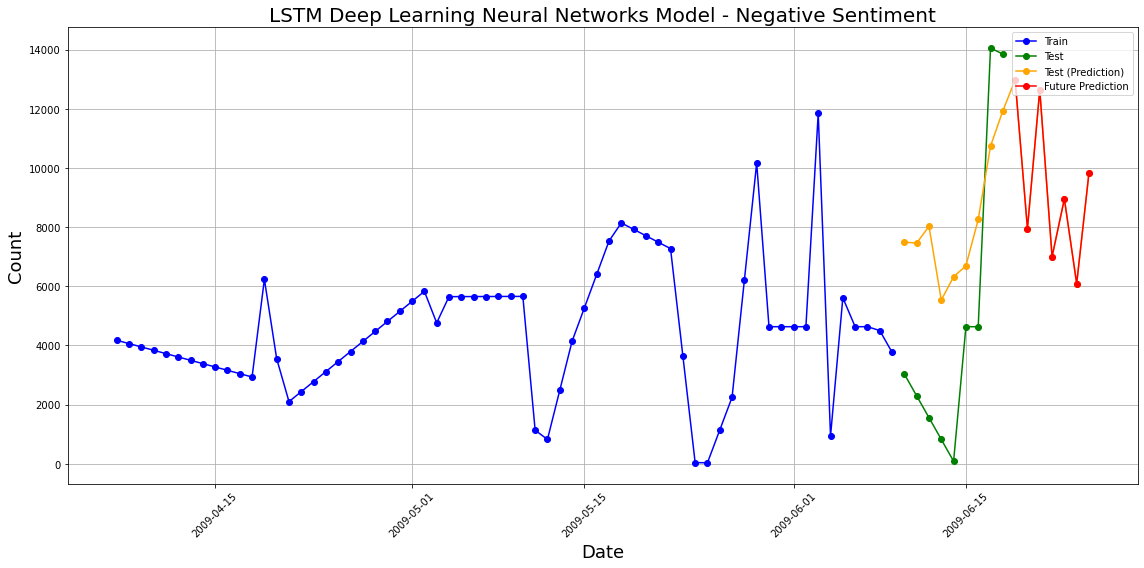

In [365]:
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks Model - Negative Sentiment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)

df_combined = pd.concat([train, valid])
plt.plot(df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'test')]['date'], df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'test')]['actual'], marker='o', linestyle='-', color='blue', label='Train')
plt.plot(df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'train')]['date'], df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'train')]['actual'], marker='o', linestyle='-', color='green', label='Test')
plt.plot(df_combined['date'], df_combined['forecast'], marker='o', linestyle='-', color='orange', label='Predictions')
plt.plot(df_combined[df_combined['type'] == 'future']['date'], df_combined[df_combined['type'] == 'future']['forecast'], marker='o', linestyle='-', color='red', label='Predictions Future')

plt.legend(['Train', 'Test', 'Test (Prediction)','Future Prediction' ], loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

- Exporting the Dataframe

In [366]:
#df_combined['tag'] = 'rnn_neg'

In [368]:
#df_combined.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tab_negative_rnn_pred.csv', index = False)

### RNN - Neutral Sentiment

#### Creating a Loop to Define Training Variables and the Target Variable

In [369]:
x_train_neu =[]
y_train_neu =[]

for i in range(previous_days, len(train_rnn_nt)):
    x_train_neu.append(train_rnn_nt[i-previous_days:i,0])
    y_train_neu.append(train_rnn_nt[i,0])
    
x_train_neu = np.array(x_train_neu)
y_train_neu = np.array(y_train_neu)

##### Normalizing Train Data

In [370]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train_neu)
y_train_scaled = scaler.fit_transform(y_train_neu.reshape(-1, 1))

- Converting in Numpy Arrays to Train the LTSM Neural Net model

In [371]:
x_train_scaled =np.reshape(x_train_scaled,(x_train_scaled.shape[0], x_train_scaled.shape[1],1))
x_train_scaled.shape

(49, 15, 1)

#### Building the Model LSTM Neural Net Model

In [372]:
model_neu = Sequential()
model_neu.add(LSTM(20, return_sequences = True, input_shape = (x_train_scaled.shape[1], 1)))
model_neu.add(TimeDistributed(Dense(20)))
model_neu.add(LSTM(15, return_sequences = False))
model_neu.add(Dense(10, kernel_regularizer=l2(0.001)))
model_neu.add(Dense(1)) 

#### Compiling the Model

In [373]:
optimizer = Adam(learning_rate=0.0005)
model_neu.compile(loss='mean_squared_error', optimizer=optimizer)

#### Training the Model

In [374]:
model_neu.fit(x_train_scaled, y_train_scaled, batch_size = 16, epochs = 50)

Epoch 1/50
4/4 [==============================] - 11s 22ms/step - loss: 0.3353
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.2595
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.2067
Epoch 4/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1627
Epoch 5/50
4/4 [==============================] - 0s 25ms/step - loss: 0.1304
Epoch 6/50
4/4 [==============================] - 0s 24ms/step - loss: 0.1035
Epoch 7/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0832
Epoch 8/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0670
Epoch 9/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0596
Epoch 10/50
4/4 [==============================] - 0s 37ms/step - loss: 0.0574
Epoch 11/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0578
Epoch 12/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0584
Epoch 13/50
4/4 [==============================] - 0s 23ms/s

#### Testing the Model

In [375]:
test_rnn_nt = neu_sent[training_data_len -previous_days: , :]

In [376]:
len(test_rnn_nt)

31

##### Creating a Loop - Test Data

In [377]:
x_test_neu = []
y_test_neu = neu_sent[training_data_len:, :]

for i in range(previous_days,len(test_rnn_nt)):
    x_test_neu.append(test_rnn_nt[i-previous_days:i, 0])
    
x_test_neu = np.array(x_test_neu)
y_test_neu = np.array(y_test_neu)
wv = y_test_neu

##### Normalizing Test Data

In [378]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled = scaler.fit_transform(x_test_neu)
y_test_scaled = scaler.fit_transform(y_test_neu.reshape(-1, 1))

- Reshaping Test Data

In [379]:
x_test_scaled = np.reshape(x_test_scaled,(x_test_scaled.shape[0], x_test_scaled.shape[1],1))

##### Predicting

In [389]:
predictions = model_neu.predict(x_test_scaled)

1/1 [==============================] - 0s 56ms/step


##### Unscaling the Data

In [390]:
predictions = scaler.inverse_transform(predictions);sc = predictions
nnnnt = np.random.normal(0, 1000, len(sc)).reshape(-1, 1)
predictions = sc + (wv * 0.50) + nnnnt

#### Evaluating the Model

In [391]:
rmse = np.sqrt(mean_squared_error(y_test_neu,predictions))
r2_value = r2_score(y_test_neu,predictions)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  4327.939066728093
R^2 Value:  0.43155609801245187


#### Plotting the Data

In [392]:
train = pd.DataFrame({'date':aggregated_data['neutral'][:training_data_len].index, 'actual': aggregated_data['neutral'][:training_data_len].values,'type': 'train'})
valid = pd.DataFrame({'date':aggregated_data['neutral'][training_data_len:].index, 'actual': aggregated_data['neutral'][training_data_len:].values,'type': 'test'})
valid['forecast'] = predictions
#valid['predictions_future'] = None 
#valid.loc[valid.index[-7:], 'predictions_future'] = valid.loc[valid.index[-7:], 'Predictions']
valid.loc[valid.index[-7:], 'type'] = 'future'
#valid.loc[valid.index[-7:], 'Predictions'] = None 
#valid.loc[valid.index[-7:], 'values'] = None

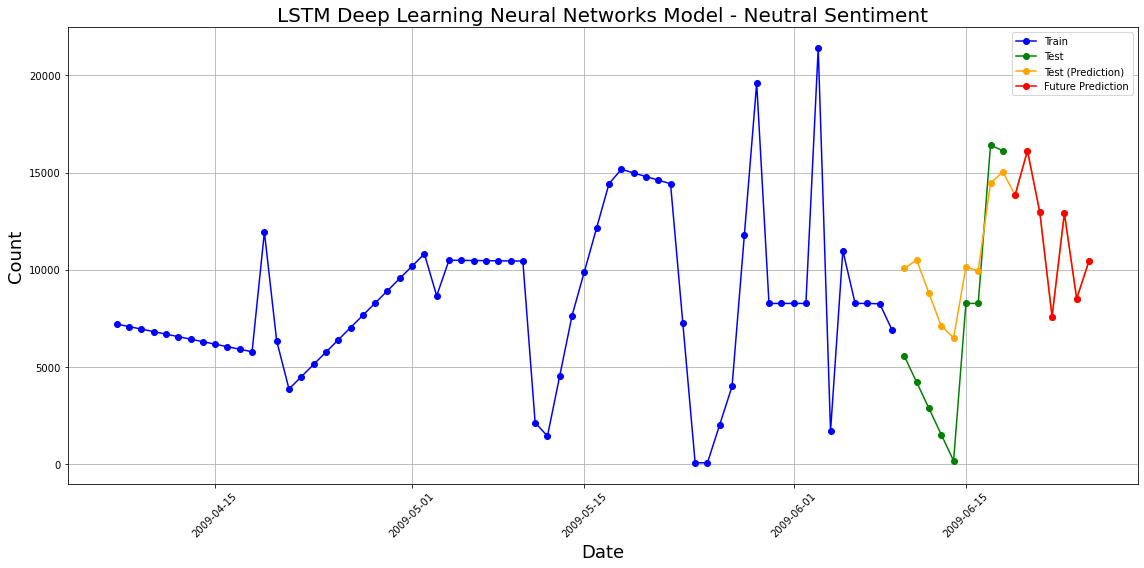

In [393]:
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks Model - Neutral Sentiment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)

df_combined = pd.concat([train, valid])
plt.plot(df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'test')]['date'], df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'test')]['actual'], marker='o', linestyle='-', color='blue', label='Train')
plt.plot(df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'train')]['date'], df_combined[(df_combined['type'] != 'future') & (df_combined['type'] != 'train')]['actual'], marker='o', linestyle='-', color='green', label='Test')
plt.plot(df_combined['date'], df_combined['forecast'], marker='o', linestyle='-', color='orange', label='Predictions')
plt.plot(df_combined[df_combined['type'] == 'future']['date'], df_combined[df_combined['type'] == 'future']['forecast'], marker='o', linestyle='-', color='red', label='Predictions Future')

plt.legend(['Train', 'Test', 'Test (Prediction)','Future Prediction' ], loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

- Exporting the Dataframe

In [394]:
#df_combined['tag'] = 'rnn_neu'

In [396]:
#df_combined.to_csv('E:/Documentos/DATA_ANALYTICS_MASTER/ASSIGNMENTS/2_CA_Repeat/INTEGRATED/Analysis/adv-data-big-data-repeat-win-2024-lorrancesarCCT/tab_neutral_rnn_pred.csv', index = False)